# ABL with MMC demo

In [1]:
# Load the modules

# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/projects/wind_uq/lcheung/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)
import MMCutil as writeMMC

# Load the libraries
import numpy as np
import pandas as pd
import amrwind_frontend as amrwind
import matplotlib.pyplot    as plt
from scipy.interpolate import CubicSpline
from scipy.signal import savgol_filter

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    return np.abs(a - a0).argmin()

In [3]:
# Merging profiles
def tanhblend(x, x0, w):
    return 0.5*(1+np.tanh((x-x0)/w))

def tanhblendprofiles(profa, profb, x, x0, w):
    tanha = profa*(1-tanhblend(x, x0, w))
    tanhb = profb*(tanhblend(x, x0, w))
    return tanha + tanhb

def interpprofile(newz, z, prof):
    spl = CubicSpline(z, prof)
    interpprof = spl(newz)
    return interpprof
    #return np.interp(newz, z, prof)
    
def blendprofiles(newz, zA, profA, Bconst, x0, w):
    newprofA = interpprofile(newz, zA, profA)
    newprofB = Bconst*np.ones(len(newz)) #interpprofile(newz, zB, profB)
    return tanhblendprofiles(newprofA, newprofB, newz, x0, w)

In [4]:
# Set up the MMC profiles
profiledir='../../HPP_Data/20240414/'
dop_heights = np.loadtxt(profiledir+'/Doppler_heights.txt')
dop_time    = np.loadtxt(profiledir+'/Doppler_time.txt')
dop_WD      = np.loadtxt(profiledir+'/Doppler_WD.txt', delimiter=',')
dop_WS      = np.loadtxt(profiledir+'/Doppler_WS.txt', delimiter=',')

MET_heights = np.loadtxt(profiledir+'/MET_heights.txt')
MET_time    = np.loadtxt(profiledir+'/MET_time.txt')
MET_WD      = np.loadtxt(profiledir+'/MET_WD.txt', delimiter=',')
MET_WS      = np.loadtxt(profiledir+'/MET_WS.txt', delimiter=',')

MET_HF      = np.loadtxt(profiledir+'/MET_Heat_Flux.txt', delimiter=',')


MET_time_sec = MET_time*3600

#print(len(MET_time))
#print(len(dop_time))
#print(dop_WS.shape)

In [5]:
# Merge the MET and lidar datasets
all_heights = np.concatenate((MET_heights, dop_heights))
allWS = []
allWD = []
for it, t in enumerate(MET_time):
    idx = find_nearest(dop_time, t)
    WS = np.concatenate((MET_WS[it, :], dop_WS[idx, :]))
    WD = np.concatenate((MET_WD[it, :], dop_WD[idx, :]))
    allWS.append(WS)
    allWD.append(WD)
    
allWS = np.array(allWS)
allWD = np.array(allWD)

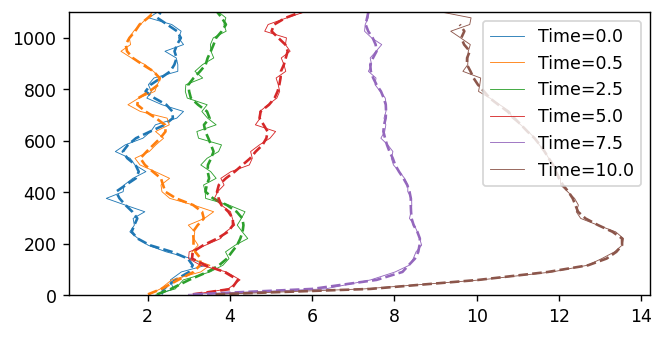

In [6]:
iplot = [0, 1, 5, 10, 15, 20]
fig,ax = plt.subplots(1,1,figsize=(6,3), dpi=125)
for i in iplot:
    t = MET_time[i]
    WSfilt = savgol_filter(allWS[i,:], 7, 3)
    line,  = ax.plot(allWS[i,:], all_heights, lw=0.5, label='Time=%0.1f'%t)
    plt.plot(WSfilt, all_heights, color=line.get_color(), linestyle='--')
    
plt.ylim([0, 1100])
plt.legend()

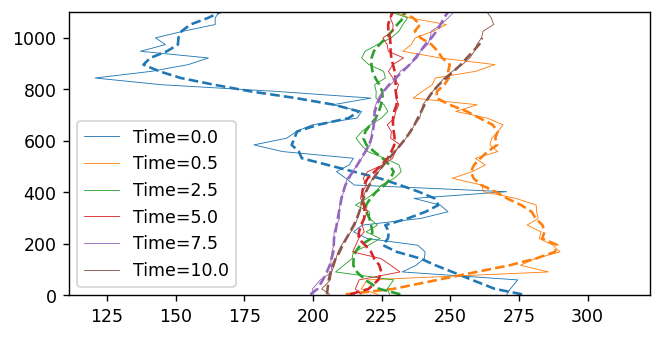

In [7]:
iplot = [0, 1, 5, 10, 15, 20]
plt.figure(figsize=(6,3), dpi=125)
for i in iplot:
    t = MET_time[i]
    WDfilt = savgol_filter(allWD[i,:], 11, 3)
    line, = plt.plot(allWD[i,:], all_heights, lw=0.5, label='Time=%0.1f'%t)
    plt.plot(WDfilt, all_heights, color=line.get_color(), linestyle='--')
    
plt.ylim([0, 1100])
plt.legend()

In [8]:
# Convert from WS to WD
all_U = []
all_V = []

for i, t in enumerate(MET_time):
    theta = (270 - allWD[i,:])*np.pi/180.0
    WS    = allWS[i,:]
    U     = WS*np.cos(theta)
    V     = WS*np.sin(theta)
    all_U.append(U)
    all_V.append(V)
    
all_U = np.array(all_U)
all_V = np.array(all_V)

In [9]:
all_heights[38]

1000.25939941406

In [10]:
filterN = 11
polyN   = 3
zblend  = 700
blendw  = 50
maxzN   = 32
all_Ublend = []
all_Vblend = []
all_Tblend = []

# Temperature profile
Tsurf = 278
Tlow  = 280
Thigh = 288
Tprof = Tsurf + (Tlow-Tsurf)/(zblend)*all_heights

# Filter and blend to constant
for i, t in enumerate(MET_time):
    Ufilt = savgol_filter(all_U[i,:], filterN, polyN)
    Vfilt = savgol_filter(all_V[i,:], filterN, polyN)
    
    Uzblend = np.interp(zblend, all_heights, Ufilt)
    Vzblend = np.interp(zblend, all_heights, Vfilt)
    
    #print(Ufilt[:maxzN])
    
    # Merge the profiles
    blendU = blendprofiles(all_heights, all_heights[:maxzN], Ufilt[:maxzN],  Uzblend, zblend, blendw)
    blendV = blendprofiles(all_heights, all_heights[:maxzN], Vfilt[:maxzN],  Vzblend, zblend, blendw)
    blendT = blendprofiles(all_heights, all_heights, Tprof,  Thigh, zblend, blendw)
    #blendT = blendprofiles(all_heights, all_heights, Tlow*np.ones(len(all_heights)),  Thigh, zblend, blendw)
    
    all_Ublend.append(blendU)
    all_Vblend.append(blendV)
    all_Tblend.append(blendT)
    
all_Ublend = np.array(all_Ublend)
all_Vblend = np.array(all_Vblend)
all_Tblend = np.array(all_Tblend)

Text(0.5, 0, 'T [K]')

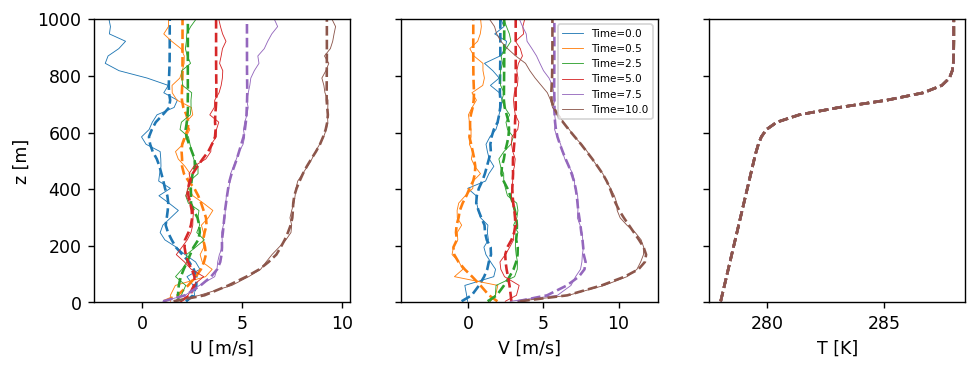

In [11]:
iplot = [0, 1, 5, 10, 15, 20]
fig, axs = plt.subplots(1,3, figsize=(9,3), dpi=125, sharey=True)
for i in iplot:
    t = MET_time[i]
    line, = axs[0].plot(all_U[i,:], all_heights, lw=0.5, label='Time=%0.1f'%t)
    axs[0].plot(all_Ublend[i,:], all_heights, color=line.get_color(), linestyle='--')
    
    axs[1].plot(all_V[i,:], all_heights, lw=0.5,  color=line.get_color(), label='Time=%0.1f'%t)
    axs[1].plot(all_Vblend[i,:], all_heights, color=line.get_color(), linestyle='--')

    axs[2].plot(all_Tblend[i,:], all_heights, color=line.get_color(), linestyle='--')

axs[0].set_ylabel('z [m]')
axs[0].set_ylim([0, 1000])
axs[1].legend(prop={'size':6})
axs[0].set_xlabel('U [m/s]')
axs[1].set_xlabel('V [m/s]')
axs[2].set_xlabel('T [K]')

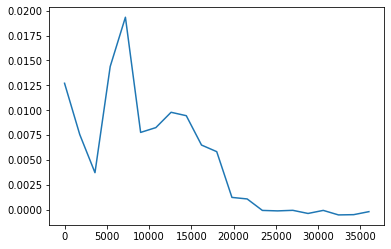

In [12]:
# Set up the temperature flux
Cp          = 1005  # J/kg-K  Specific heat of air
rho         = 1.2456
q           = MET_HF[:,1]
fluxdat     = 0.1*q/(rho*Cp) #0.0*np.array(MET_time_sec)


plt.plot(MET_time_sec, fluxdat)

In [13]:
# Save the data to text files
np.savetxt('MMC_Ublend.dat', all_Ublend)
np.savetxt('MMC_Vblend.dat', all_Vblend)
np.savetxt('MMC_all_heights.dat', all_heights)
np.savetxt('MMC_time_sec.dat', MET_time_sec)

In [14]:
# Start the case
case = amrwind.MyApp.init_nogui()

In [15]:
# Set the time constants
case.setAMRWindInput('time.stop_time', 36000.0)
case.setAMRWindInput('time.max_step',  -1)

case.setAMRWindInput('time.fixed_dt',  0.50)
case.setAMRWindInput('time.checkpoint_interval',  -1)

In [16]:
# Set some basic parameters
case.setAMRWindInput('incflo.physics',      ['ABL'])  # Must have ABL physics to do ABL calculations
case.setAMRWindInput('incflo.verbose',      3)        # This is optional, verbose=3 means more info in the output logs
case.setAMRWindInput('io.check_file',       'chk')    # What to name the checkpoint files

case.setAMRWindInput('incflo.use_godunov',  True)       # Always use a godunov scheme
case.setAMRWindInput('incflo.godunov_type', 'weno_z')   # Use 'weno_z' 

case.setAMRWindInput('turbulence.model',    ['OneEqKsgsM84'])    # One equation k-sgs subgrid scale model
case.setAMRWindInput('TKE.source_terms',    ['KsgsM84Src'])      # The corresponding source term

case.setAMRWindInput('transport.viscosity', 1.771e-05)           # dynamic viscosity, based on median air temperature of 284.47 K from 2 m above E06, units Pa-s
case.setAMRWindInput('incflo.density',      rho)                 # density, based on 1017.13*100./(284.47)/287.058 where 1017.13 is median air pressure from 2 m above E06 
                                                                 #   and 284.47 is median air temperature from 2 m above E06, units kg/
case.setAMRWindInput('incflo.velocity',      [0, 0, 0])

In [17]:
# To set up the sampling output
case.setAMRWindInput('time.plot_interval',        -1) 

In [18]:
# Set some tolerances (leave this alone)
tols = """
nodal_proj.mg_rtol                       = 1e-06               
nodal_proj.mg_atol                       = 1e-12               
mac_proj.mg_rtol                         = 1e-06               
mac_proj.mg_atol                         = 1e-12               
diffusion.mg_rtol                        = 1e-06               
diffusion.mg_atol                        = 1e-12               
temperature_diffusion.mg_rtol            = 1e-10               
temperature_diffusion.mg_atol            = 1e-13               
"""
case.loadAMRWindInput(tols, string=True);

#case.setAMRWindInput('incflo.do_initial_proj', 0)
#case.setAMRWindInput('incflo.initial_iterations', 0)


In [19]:
# Sets up the domain and level 0 mesh
case.setAMRWindInput('geometry.prob_lo', [   0.0,    0.0, 0.0 ])
case.setAMRWindInput('geometry.prob_hi', [1920.0,  1920.0, 960.0])   # each number must be divisible by 16
case.setAMRWindInput('amr.n_cell',       [96,      96,     48])

In [20]:
# This cell sets up boundary conditions
case.setAMRWindInput('is_periodicx', True)     # periodic in x
case.setAMRWindInput('is_periodicy', True)     # periodic in y
case.setAMRWindInput('is_periodicz', False)    # Enforce some boundary conditions in z

In [21]:
# Boundary conditions in z
case.setAMRWindInput('zlo.type',              'wall_model')          
case.setAMRWindInput('zlo.tke_type',          'zero_gradient')       
case.setAMRWindInput('zhi.type',              'slip_wall')           
case.setAMRWindInput('zhi.temperature_type',  'fixed_gradient')    

In [22]:
# Now set up ABL specific forces, parameters, etc.
case.setAMRWindInput('ICNS.source_terms',            ['BoussinesqBuoyancy','ABLMesoForcingMom',])
#case.setAMRWindInput('Temperature.source_terms',     ['ABLMesoForcingTemp',])

case.setAMRWindInput('ABL.stats_output_frequency',   1, forcechange=True)           # Output ABL stats every iteration            
case.setAMRWindInput('ABL.stats_output_format',   'netcdf', forcechange=True)       # Use netcdf output because that's how we postprocess

case.setAMRWindInput('ABLForcing.abl_forcing_height',   150)       # Hub height wind speed you want specify 
case.setAMRWindInput('ABL.kappa',                       0.4)      # Kolmogorov constant

case.setAMRWindInput('ABL.normal_direction',      2)              # vertical is in z
case.setAMRWindInput('ABL.surface_roughness_z0',  0.0001)           # Surface roughess, SOMETHING WE WILL PROBABLY WANT TO ITERATE ON
case.setAMRWindInput('ABL.reference_temperature', 300.0)        # Correspond to what was measured at ARM

case.setAMRWindInput('ABL.perturb_temperature',    True, forcechange=True)
case.setAMRWindInput('ABL.perturb_velocity',       True, forcechange=True)

# Monin-Obukhov parameters (No need to change)
case.setAMRWindInput('ABL.mo_beta_m',             16.0)
case.setAMRWindInput('ABL.mo_gamma_m',            5.0)
case.setAMRWindInput('ABL.mo_gamma_h',            5.0)
case.setAMRWindInput('ABL.random_gauss_mean',     0.0)
case.setAMRWindInput('ABL.random_gauss_var',      1.0)

case.setAMRWindInput('BoussinesqBuoyancy.reference_temperature', 300.0)

CANNOT update: ABLMeanBoussinesq use forcechange=True in setval()


## Add sampling planes

In [23]:
# Delete all old sampling planes from precursor
case.listboxpopupwindict['listboxsampling'].deleteall()
case.listboxpopupwindict['listboxpostprosetup'].deleteall()

In [24]:
samplingcsv="""
# CSV file should have columns withturbinescsv=
# name, type, upstream, downstream, lateral, below, above, n1, n2, options
name, type, upstream, downstream, lateral, below, above, n1, n2, options
#cl1, centerline, 1,  0, none, none,  none,  11, 11, none
#rp1, rotorplane, 2,  0, none, none,  none,  11, 11, none
#sw1, streamwise, 2,  1, 1, 0.5,  0.5,  11, 11, usedx:0.25 noffsets:1
sw1, streamwise,  2,  1, 1, 0.5,  0.5,  11, 11, usedx:10 wholedomain:1 units:meter center:specified centerx:500 centery:500 centerz:90 orientation:y outputvars:velocity;tke;temperature outputfreq:10 outputto:sw_
hh,  hubheight,   0,  0,1000, 0,  none,  11, 11, usedx:10 wholedomain:1 units:meter center:specified centerx:0 centery:0 centerz:90 outputvars:velocity;tke;temperature outputfreq:10 outputto:hubheight_
"""

In [25]:
case.setAMRWindInput('sampling_csvtextbox', samplingcsv)
case.setAMRWindInput('sampling_deleteprev', True)
case.sampling_createAllProbes(verbose=False)
# Print out existing list of turbines
print(case.listboxpopupwindict['listboxsampling'].getitemlist())

['Farm_sw1', 'Farm_hh']


## MMC parameters

In [26]:
rundir      = 'MMC_HPP04/'
ICfilename  = 'init.nc'
MMCfilename = 'MMC.nc'
amrfilename = 'abl_HPP_MMC.inp'

# Go to the run directory
if not os.path.exists(rundir):
    os.makedirs(rundir)

In [27]:
tstart      = 0.0

In [28]:
# Set the MMC inputs
zstr, Tstr = writeMMC.makeIC_fromMMC(case.getAMRWindInput('geometry.prob_lo'), 
                                     case.getAMRWindInput('geometry.prob_hi'), 
                                     case.getAMRWindInput('amr.n_cell'), 
                                     all_Ublend, all_Vblend, all_Tblend,
                                     MET_time_sec, all_heights, rundir+'/'+ICfilename, tstart, verbose=True)
writeMMC.makeMMCforcing(case.getAMRWindInput('geometry.prob_lo'), 
                        case.getAMRWindInput('geometry.prob_hi'), 
                        case.getAMRWindInput('amr.n_cell'), 
                        all_Ublend, all_Vblend, all_Tblend, fluxdat,
                        MET_time_sec, all_heights, rundir+'/'+MMCfilename)

# These inputs set up the initial temperature profile (Same as Nalu-Wind temperature profile)
case.setAMRWindInput('ABL.temperature_heights', zstr)
case.setAMRWindInput('ABL.temperature_values',  Tstr)

# MMC files
case.setAMRWindInput('ABL.initial_condition_input_file', ICfilename) # this is only for u,v
case.setAMRWindInput('ABL.mesoscale_forcing', MMCfilename)

case.setAMRWindInput('ABLMesoForcingMom.forcing_scheme', "direct")
#case.setAMRWindInput('ABLMesoForcingTemp.forcing_scheme', "direct")

#case.setAMRWindInput('ABLMesoForcingMom.forcing_transition',  "directToConstant")
#case.setAMRWindInput('ABLMesoForcingTemp.forcing_transition', "directToConstant")
#case.setAMRWindInput('ABLMesoForcingMom.constant_transition_height',  450.0)
#case.setAMRWindInput('ABLMesoForcingTemp.constant_transition_height', 450.0)
#case.setAMRWindInput('ABLMesoForcingMom.transition_thickness',  100.0)
#case.setAMRWindInput('ABLMesoForcingTemp.transition_thickness', 100.0)

[============================================================] 100.0% 
[============================================================] 100.0% 
[============================================================] 100.0% 
NETCDF4
Wrote heights and times
Wrote momentum profiles
Wrote temperature profiles
Wrote tflux profiles
Done


In [29]:
# Estimate mesh size
case.estimateMeshSize(verbose=False)

ESTIMATED MESH SIZE
   Level       Ncells                      Cell Size
       0       442368             20.0 x 20.0 x 20.0
  TOTAL:       442368


In [30]:
# Write the input file
print(case.writeAMRWindInput(rundir+'/'+amrfilename))

# --- Simulation time control parameters ---
time.stop_time                           = 36000.0             # Max (simulated) time to evolve [s]
time.max_step                            = -1                  
time.fixed_dt                            = 0.5                 # Fixed timestep size (in seconds). If negative, then time.cfl is used
time.checkpoint_interval                 = -1                  
incflo.physics                           = ABL                 # List of physics models to include in simulation.
incflo.verbose                           = 3                   
io.check_file                            = chk                 
incflo.use_godunov                       = true                
incflo.godunov_type                      = weno_z              
turbulence.model                         = OneEqKsgsM84        
TKE.source_terms                         = KsgsM84Src          
nodal_proj.mg_rtol                       = 1e-06               
nodal_proj.mg_atol             